Want to show that the compression of the digit (log evidence) is already enough for classification and to find out which digits may be similar.



- [ ] Calculate log evidence of whole digit 
    - [ ] Absolute value per digit => how compressible is that digit
    - [ ] Q: even without testing looking for the best model will already classify the digit, simply because some digits are more compressible than others
    - [ ] Log evidence distribution
    - [ ] Y = log evidence for actual model on whole dataset fitted
        - [ ] Each line is a digit 
    - [ ] X = 20x 20 digits for each fit MCM and compute distribution of log evidence
    - [ ] Dont divide by 121 so its bitwise 
    - [ ] Without testing, simple choice of model 
    - [ ] Measure of compressibility is enough to classify


In [1]:
# 1. need for each digit the image/bitwise evidence of the full MCM (6313 samples) -> 10 numbers
# 2. For N = 20 (make this variable maybe wanna try our 100 too) compute the log evidence for multiple runs for all digits -> runs*10 numbers

In [2]:
# 1. 


In [40]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import numpy as np
from src.loaders import load_data, load_labels
from src.classify import MCM_Classifier
import os
import src.plot as myplot
import scipy.ndimage as ndi

In [41]:
import importlib
import src.plot as myplot
importlib.reload(myplot)

<module 'src.plot' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/mcm/paper_plots/../src/plot.py'>

In [42]:

import importlib
import src.paper_utils as utils
importlib.reload(utils)

<module 'src.paper_utils' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/mcm/paper_plots/../src/paper_utils.py'>

In [43]:
# Ps = classifier.get_P() # category, icc in MCM, 2**rank_icc probability distribution
# MCMs = classifier.get_MCMs()
# Counts = classifier.get_Counts()
# N = Counts[0][0].sum().astype(int) 


In [61]:

def get_evds_imagewise(MCMs, Counts, N, image_wise=True):
    """Calculate the image-wise evidence for each MCM.

    This function calculates the image-wise log evidence for each MCM (Model Comparison Model) 
    based on the given counts and MCMs. The evidence is calculated using the `evidence_iccs` 
    and `pixelwise_evidence` functions from the `utils` module.

    :param MCMs: The list of MCMs.
    :type MCMs: list
    :param Counts: The counts.
    :type Counts: numpy.ndarray
    :param N: The value of N.
    :type N: int
    :return: The array of image-wise evidence for each MCM.
    :rtype: numpy.ndarray
    """
    evds = []
    for mcm_idx in np.arange(10):
        evd = utils.evidence_iccs(Counts, MCMs, mcm_idx)
        evd = utils.pixelwise_evidence(evd, N, MCMs[mcm_idx], image_wise=image_wise) 
        evd = np.sum(evd) # image wise overall evidence of the model
        evds.append(evd)
    return np.array(evds)

full_evds = get_evds_imagewise(MCMs_full,Counts_full, sample_sizes_full[0])


In [134]:
# load evidence for all samples sizes, runs, MCMs
def load_all_evds(sample_sizes, n_runs,path_format="../data/OUTPUT/mcm/sample_sizes_fromfull", image_wise=True):
    
    counts_samplesizes, mcms_samplesizes = utils.load_counts_mcm(sample_sizes, "",path_format)
    size_run_evds = np.empty((len(sample_sizes), n_runs, 10))
    for iss, n in enumerate(sample_sizes):
        for r in range(n_runs):
            size_run_evds[iss,r,:] = get_evds_imagewise(mcms_samplesizes[iss][r],counts_samplesizes[iss][r], sample_sizes[iss],image_wise=image_wise)



    return size_run_evds

In [137]:
sample_sizes = [100, 6315]
nruns = 50 # have that many not for all n values
all_size_run_evds = load_all_evds(sample_sizes, nruns)

Text(0.5, 1.0, 'Compression enough to classify. Bitwise logE for each MCM \n comparing full (6315 vs 100) sample. \n 50 runs each. ')

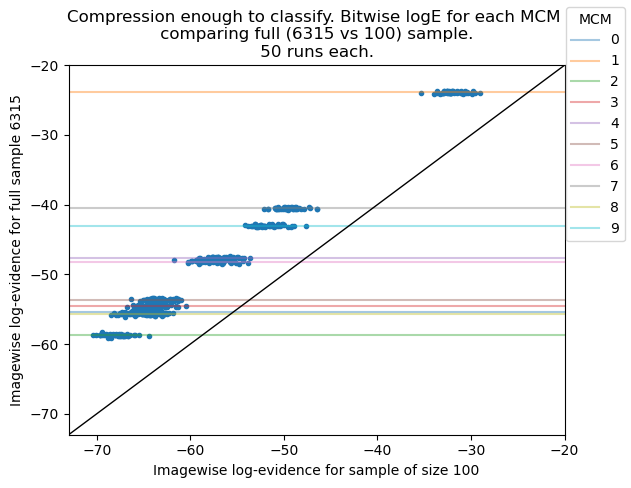

In [138]:

fig, ax = plt.subplots(1,1)
digit_colors = myplot.get_list_fromcmap("tab10", N=10)

for i in range(10):
    ax.axhline(all_size_run_evds[-1].mean(axis=0)[i], color=digit_colors[i],label=i,alpha=.4)

ax.scatter(all_size_run_evds[sample_sizes.index(100)],all_size_run_evds[sample_sizes.index(6315)],marker=".")

ax.axline((0, 0), (1, 1), linewidth=1, color='k') 
ax.set(xlim=(-73,-20), ylim=(-73,-20))
fig.legend(title="MCM")
# plt.gca().set_aspect("equal", "box")
ax.set_ylabel(f"Imagewise log-evidence for full sample {sample_sizes[-1]}")
ax.set_xlabel(f"Imagewise log-evidence for sample of size {sample_sizes[0]}")
ax.set_title(f"Compression enough to classify. Bitwise logE for each MCM \n comparing full (6315 vs 100) sample. \n {nruns} runs each. ")


In [141]:
# now do the same but we calculate logE average and std per digit as separte lines over N

sample_sizes = [10] + list(np.arange(100,5900,100)) + [6315]
nruns = 10
all_size_run_evds = load_all_evds(sample_sizes, nruns)

In [147]:
means[:,i].shape

(60,)

Text(0.5, 1.0, 'Compression enough to classify.\n Bitwise logE over samples used for MCM fitting. \n  Error bars are std over runs 10. ')

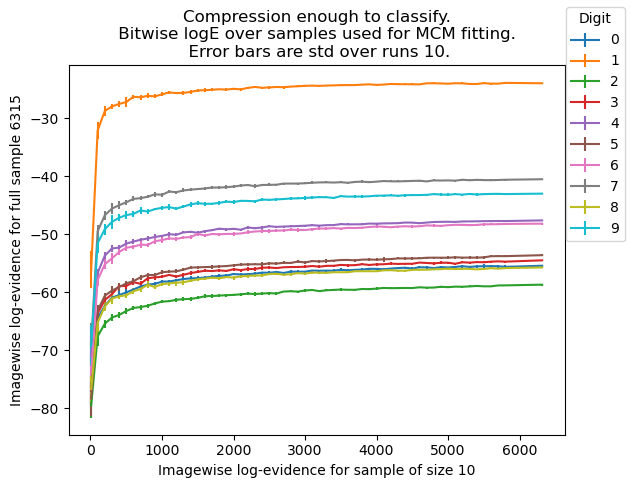

In [161]:
fig, ax = plt.subplots(1,1)
digit_colors = myplot.get_list_fromcmap("tab10", N=10)

means = all_size_run_evds.mean(axis=1)
stds = np.std(all_size_run_evds,axis=1)


# means = all_size_run_evds.mean(axis=1) - all_size_run_evds[:,-1]
# stds = np.std(all_size_run_evds-all_size_run_evds[:,-1,None],axis=1)
for i, dcol in enumerate(digit_colors):
    ax.errorbar(sample_sizes, means[:,i], yerr=stds[:,i], label=str(i), color=dcol)



fig.legend(title="Digit")
# plt.gca().set_aspect("equal", "box")
ax.set_ylabel(f"Imagewise log-evidence for full sample {sample_sizes[-1]}")
ax.set_xlabel(f"Imagewise log-evidence for sample of size {sample_sizes[0]}")
ax.set_title(f"Compression enough to classify.\n Bitwise logE over samples used for MCM fitting. \n  Error bars are std over runs {nruns}. ")
